In [1]:
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import datetime as dt
import time
import statistics

In [2]:
mkfunc2 = lambda x, pos: "2/"+time.ctime(x+9*3600)[8:16]
mkformatter2 = matplotlib.ticker.FuncFormatter(mkfunc2)

In [3]:
#prp_node_models={}
#with open("prp_node_models.csv") as fd:
#    for line in fd.readlines():
#        larr.line.strip().split(",",1)
#        prp_node_models[larr[0].replace(".","-")]=larr[1]

In [4]:
with open("runtimes.csv","r") as fd: lines=fd.readlines()


In [5]:
def parse(lines, cpus=2, sstrs=["2"]):
    data={}
    for line in lines[1:]:
      larr=line.strip().split(",")
      #print(larr)
      if len(larr)!=9:
        continue

      found=False
      for sstr in sstrs:
        if larr[8].strip().startswith(sstr):
          found=True
      if not found:
        continue

      if int(float(larr[1].strip()))!=cpus:
        continue
        
      narr=larr[6].strip().split(".")
      if len(narr)<4:
            continue # old style log entry, ignore
      n=narr[1] # node name
      d=narr[-1] #domain
      k = larr[3].strip()
      if k=="":
          kidx=int(larr[4].split('/')[1])
          if kidx<1:
            k="A100-SXM4-40GB MIG 7g.40gb"
          elif kidx<3:
            k="A100-SXM4-40GB MIG 3g.20gb"
          elif kidx<7:
            k="A100-SXM4-40GB MIG 2g.10gb"
          else:
            k="A100-SXM4-40GB MIG 1g.5gb"
      if d=="com": # google
        if n.find("ts")<0:
            mtype=n.split("-")[2]
        else:
            mtype=n.split("-")[3]
        if mtype.startswith("pa100m"):
            mtype=mtype[6:]+"xMIG"
        elif mtype.startswith("pa100t"):
            mtype=mtype[6:]+"xshared"
        elif mtype.startswith("pv100t"):
            mtype=mtype[6:]+"xshared"
        elif mtype.startswith("pt4t"):
            mtype=mtype[4:]+"xshared"
        else:
            mtype=""

        k=k + " gke " + mtype
      elif d=="io":
        k=k+ " prp"
        if k.find("MIG 2g.10gb")>=0:
            k=k+" 3xMIG"
        elif k.find("MIG 3g.20gb")>=0:
            k=k+" 2xMIG"
      else:
        #k=k+ " unknown"
        continue # old style, ignore
      val=int(larr[7])

      if k not in data:
        data[k]=[]
      data[k].append(val)
    return data


In [6]:
def get_means(data, maxv=3600):
    means={}
    medians={}
    throughput={}
    for k in data:
        multiplier=1
        midx=k.find("xMIG")
        if midx>0:
            multiplier=int(k[midx-1])
        else:
            midx=k.find("xsha")
            if midx>0:
                multiplier=int(k[midx-1])
        els=[]
        for val in data[k]:
            if val<maxv: # strip out outliers
                els.append(val)
        means[k] = statistics.mean(els)
        medians[k] = statistics.median(els)
        throughput[k] = multiplier * 24*3600/means[k]
    return (means,medians,throughput)

In [7]:
def save(data,means,medians,throughput,fname):
    with open(fname,"w") as fd:
        fd.write("#GPU, mean, median, throughput\n")
        klist=list(data.keys())
        klist.sort()
        for k in klist:
            fd.write("#%s, %i, %i, %i\n"%(k,means[k],medians[k],throughput[k]))
        #fd.write("#GPU, walltime\n")
        #for k in klist:
        #    for val in data[k]:
        #        fd.write("%s, %i\n"%(k,val))

In [8]:
def hvals(data, minv=0, maxv=3600, bins=20):
    rtimes=set()
    for k in data:
        rtimes = rtimes.union(data[k])

    rmin=max( (min(rtimes),minv) )
    rmax=min( (max(rtimes),maxv) )+1
    dr=(rmax-rmin)/float(bins)
    del rtimes
    
    data_times=[]
    data_values={}
    for k in data:
        data_values[k] = []
    for i in range(bins):
        data_times.append(int(rmin+dr/2+dr*i))
        for k in data:
            data_values[k].append(0)
    for k in data:
        nels=len(data[k])
        for ival in data[k]:
            val = min(max(rmin,ival),rmax-1) 
            b=int((val-rmin)/dr)
            data_values[k][b]+=1.0/nels
    return (data_times, data_values)

In [9]:
data=parse(lines, 2,["2022-03"])
means,medians,throughput=get_means(data)
save(data,means,medians,throughput,"runtimes.o4.all_c2.csv")
rtimes,rvals=hvals(data,maxv=2200,bins=20)

In [10]:
#print(data.keys())
#print(rtimes)
#print(rvals)

  880  1392  1404   434 A100-SXM4-40GB MIG 1g.5gb gke 7xMIG
  369   970   972   267 A100-SXM4-40GB MIG 2g.10gb gke 3xMIG
  143   908   900   190 A100-SXM4-40GB MIG 3g.20gb gke 2xMIG
  108   824   828   104 A100-SXM4-40GB MIG 7g.40gb gke 1xMIG
   74   852   864   101 A100-SXM4-40GB gke 
   63   874   864   197 A100-SXM4-40GB gke 2xshared
  161   928   936   279 A100-SXM4-40GB gke 3xshared
   92   976   972   353 A100-SXM4-40GB gke 4xshared
  146  1211  1188   499 A100-SXM4-40GB gke 7xshared
  539   844   828   306 NVIDIA A100-PCIE-40GB MIG 2g.10gb prp 3xMIG
  458   656   648   263 NVIDIA A100-PCIE-40GB MIG 3g.20gb prp 2xMIG
  531   581   576   148 NVIDIA A100-PCIE-40GB prp


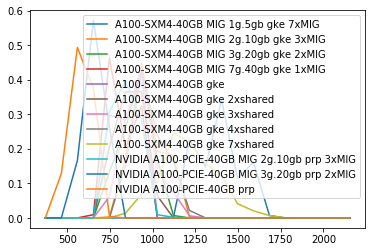

In [11]:
rkeys=list(rvals.keys())
rkeys.sort()
for k in rkeys:
    if k.find("A100")<0:
        continue
    plt.plot(rtimes, rvals[k], label=k)
    print("%5i %5i %5i %5i %s"%(len(data[k]),means[k],medians[k],throughput[k],k))
plt.legend(loc=1)
plt.show()

  539   844   828   306 NVIDIA A100-PCIE-40GB MIG 2g.10gb prp 3xMIG
  458   656   648   263 NVIDIA A100-PCIE-40GB MIG 3g.20gb prp 2xMIG
  531   581   576   148 NVIDIA A100-PCIE-40GB prp


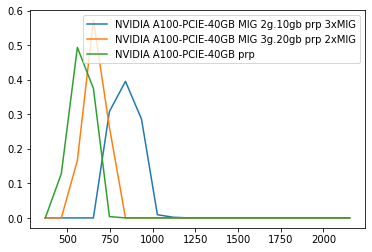

In [12]:
rkeys=list(rvals.keys())
rkeys.sort()
for k in rkeys:
    if k.find("A100")<0:
        continue
    if k.find("prp")<0:
        continue

    plt.plot(rtimes, rvals[k], label=k)
    print("%5i %5i %5i %5i %s"%(len(data[k]),means[k],medians[k],throughput[k],k))
plt.legend(loc=1)
plt.savefig("o4_prp_a100mig.png", format="png")
plt.savefig("o4_prp_a100mig.svg", format="svg")
plt.show()


   74   852   864   101 A100-SXM4-40GB gke 
   63   874   864   197 A100-SXM4-40GB gke 2xshared
  161   928   936   279 A100-SXM4-40GB gke 3xshared
   92   976   972   353 A100-SXM4-40GB gke 4xshared
  146  1211  1188   499 A100-SXM4-40GB gke 7xshared


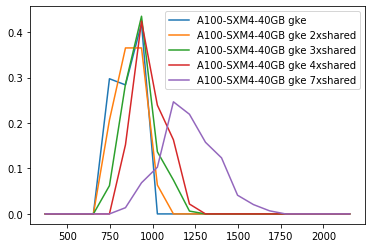

In [13]:
rkeys=list(rvals.keys())
rkeys.sort()
for k in rkeys:
    if k.find("A100")<0:
        continue
    if k.find("prp")>=0:
        continue
    if k.find("MIG")>=0:
        continue


    plt.plot(rtimes, rvals[k], label=k)
    print("%5i %5i %5i %5i %s"%(len(data[k]),means[k],medians[k],throughput[k],k))
plt.legend(loc=1)
plt.savefig("o4_gke_a100shr.png", format="png")
plt.savefig("o4_gke_a100shr.svg", format="svg")
plt.show()

  880  1392  1404   434 A100-SXM4-40GB MIG 1g.5gb gke 7xMIG
  369   970   972   267 A100-SXM4-40GB MIG 2g.10gb gke 3xMIG
  143   908   900   190 A100-SXM4-40GB MIG 3g.20gb gke 2xMIG
  108   824   828   104 A100-SXM4-40GB MIG 7g.40gb gke 1xMIG


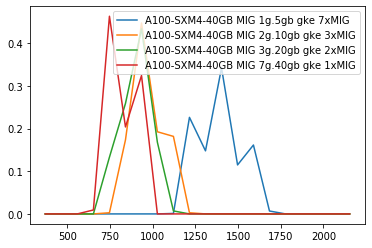

In [14]:
rkeys=list(rvals.keys())
rkeys.sort()
for k in rkeys:
    if k.find("A100")<0:
        continue
    if k.find("MIG")<0:
        continue
    if k.find("prp")>=0:
        continue

    plt.plot(rtimes, rvals[k], label=k)
    print("%5i %5i %5i %5i %s"%(len(data[k]),means[k],medians[k],throughput[k],k))
plt.legend(loc=1)
plt.savefig("o4_gke_a100mig.png", format="png")
plt.savefig("o4_gke_a100mig.svg", format="svg")
plt.show()

   98   879   864    98 Tesla V100-SXM2-16GB gke 
  226  1064  1080   162 Tesla V100-SXM2-16GB gke 2xshared


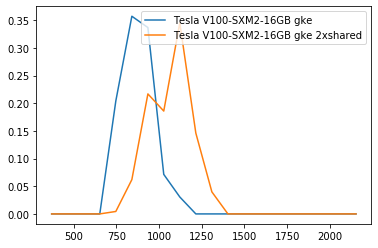

In [15]:
rkeys=list(rvals.keys())
rkeys.sort()
for k in rkeys:
    if not k.startswith("Tesla V"):
        continue
    if k.find("prp")>=0:
        continue

    plt.plot(rtimes, rvals[k], label=k)
    print("%5i %5i %5i %5i %s"%(len(data[k]),means[k],medians[k],throughput[k],k))
plt.legend(loc=1)
plt.savefig("o4_gke_v100shr.png", format="png")
plt.savefig("o4_gke_v100shr.svg", format="svg")
plt.show()

  353   865   864    99 Tesla T4 gke 
  226  1142  1152   151 Tesla T4 gke 2xshared


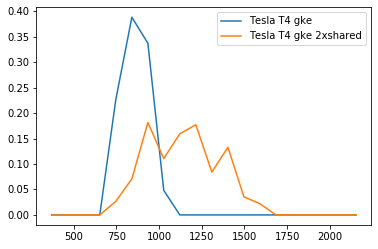

In [16]:
rkeys=list(rvals.keys())
rkeys.sort()
for k in rkeys:
    if not k.startswith("Tesla T"):
        continue
    if k.find("prp")>=0:
        continue

    plt.plot(rtimes, rvals[k], label=k)
    print("%5i %5i %5i %5i %s"%(len(data[k]),means[k],medians[k],throughput[k],k))
plt.legend(loc=1)
plt.savefig("o4_gke_t4shr.png", format="png")
plt.savefig("o4_gke_t4shr.svg", format="svg")
plt.show()

In [17]:
#data=parse(lines,2,"2022-03")
#means,medians=get_means(data)
#rtimes,rvals=hvals(data,bins=20)
#save(data,means,medians,"runtimes.prp_c2.csv")

In [18]:
data=parse(lines, 2,["2022-03"])
means,medians,throughput=get_means(data)
rtimes,rvals=hvals(data,maxv=3600,bins=30)

  880  1392  1404   434 A100-SXM4-40GB MIG 1g.5gb gke 7xMIG
  369   970   972   267 A100-SXM4-40GB MIG 2g.10gb gke 3xMIG
  143   908   900   190 A100-SXM4-40GB MIG 3g.20gb gke 2xMIG
  108   824   828   104 A100-SXM4-40GB MIG 7g.40gb gke 1xMIG
   74   852   864   101 A100-SXM4-40GB gke 
   63   874   864   197 A100-SXM4-40GB gke 2xshared
  161   928   936   279 A100-SXM4-40GB gke 3xshared
   92   976   972   353 A100-SXM4-40GB gke 4xshared
  146  1211  1188   499 A100-SXM4-40GB gke 7xshared
  539   844   828   306 NVIDIA A100-PCIE-40GB MIG 2g.10gb prp 3xMIG
  458   656   648   263 NVIDIA A100-PCIE-40GB MIG 3g.20gb prp 2xMIG
  531   581   576   148 NVIDIA A100-PCIE-40GB prp
 4142   554   540   155 NVIDIA A40 prp
  703  1044  1044    82 NVIDIA GeForce GTX 1070 prp
16639   764   720   113 NVIDIA GeForce GTX 1080 Ti prp
11869   760   756   113 NVIDIA GeForce GTX 1080 prp
18302   778   756   111 NVIDIA GeForce RTX 2080 Ti prp
 2393   450   396   191 NVIDIA GeForce RTX 3090 prp
 1832   666   

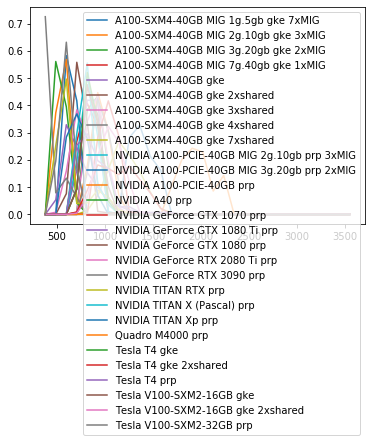

In [19]:
rkeys=list(rvals.keys())
rkeys.sort()
for k in rkeys:
    #if k.endswith("are"):
    #    continue
    plt.plot(rtimes, rvals[k], label=k)
    print("%5i %5i %5i %5i %s"%(len(data[k]),means[k],medians[k],throughput[k],k))
plt.legend()
plt.show()

 4142   554   540   155 NVIDIA A40 prp
  703  1044  1044    82 NVIDIA GeForce GTX 1070 prp
16639   764   720   113 NVIDIA GeForce GTX 1080 Ti prp
11869   760   756   113 NVIDIA GeForce GTX 1080 prp
18302   778   756   111 NVIDIA GeForce RTX 2080 Ti prp
 2393   450   396   191 NVIDIA GeForce RTX 3090 prp
 1832   666   612   129 NVIDIA TITAN RTX prp
   27   812   792   106 NVIDIA TITAN X (Pascal) prp
  141   737   720   117 NVIDIA TITAN Xp prp
   70  1950  1908    44 Quadro M4000 prp


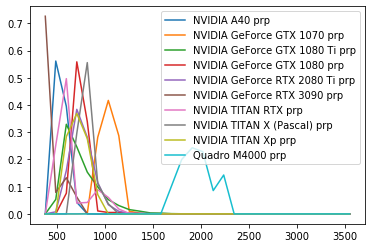

In [20]:
rkeys=list(rvals.keys())
rkeys.sort()
for k in rkeys:
    if k.find("100")>0 or k.find("T4")>0:
        continue
    plt.plot(rtimes, rvals[k], label=k)
    print("%5i %5i %5i %5i %s"%(len(data[k]),means[k],medians[k],throughput[k],k))
plt.legend()
plt.show()